In [38]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional

from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.utils import plot_model

import warnings
from textwrap import wrap

In [2]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"mennaseleem","key":"900512d2e362650271c3b939f7c65d35"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!kaggle datasets download -d adityajn105/flickr8k

 99% 1.03G/1.04G [00:09<00:00, 103MB/s] 
100% 1.04G/1.04G [00:09<00:00, 117MB/s]


In [4]:
!pip install patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 1.7 MB/s eta 0:00:00


In [5]:
import patoolib

In [6]:
patoolib.extract_archive('/content/flickr8k.zip')

patool: Extracting /content/flickr8k.zip ...
patool: running /usr/bin/7z x -o./Unpack_sv9a9fdm -- /content/flickr8k.zip
patool: ... /content/flickr8k.zip extracted to `flickr8k' (multiple files in root).


'flickr8k'

In [23]:
base = 'flickr8k'

In [24]:
image_path = '/content/flickr8k/Images'

In [4]:
data = pd.read_csv('/content/flickr8k/captions.txt')

In [ ]:
data.head()

In [ ]:
import joblib
features = joblib.load('features')

In [ ]:
with open(os.path.join(base, 'captions.txt'), 'r') as f:
  next(f)
  captions = f.read()

In [ ]:
captions

In [13]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

directory = os.path.join(base, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file

    # extract features
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature


100%|██████████| 8091/8091 [00:00<00:00, 829328.29it/s]


In [ ]:
mapping = {}
# process lines
for line in tqdm(captions.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, captions = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    captions = " ".join(captions)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(captions)

In [ ]:
len(mapping)

In [ ]:
mapping['1000268201_693b08cb0e']

In [ ]:
mapping[image_id]

In [ ]:
image_id

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = '< ' + " ".join([word for word in caption.split() if len(word)>1]) + ' >'
            captions[i] = caption

In [ ]:
clean(mapping)

In [ ]:
mapping[image_id]

In [ ]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "< "+data['caption']+" >"
    return data

In [ ]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

In [100]:
#captions

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)


images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

In [ ]:
"""""
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature
"""""

'""\nmodel = DenseNet201()\nfe = Model(inputs=model.input, outputs=model.layers[-2].output)\n\nimg_size = 224\nfeatures = {}\nfor image in tqdm(data[\'image\'].unique().tolist()):\n    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))\n    img = img_to_array(img)\n    img = img/255.\n    img = np.expand_dims(img,axis=0)\n    feature = fe.predict(img, verbose=0)\n    features[image] = feature\n'

In [ ]:
import joblib
#joblib.dump(features, 'features2') # model name
features = joblib.load('features2')

In [ ]:
class data_gen(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()
        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

In [ ]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

fe1 = Dense(256, activation='relu')(input1)
reshaped = Reshape((1, 256), input_shape=(256,))(fe1)

# sequence feature layers
se1 = Embedding(vocab_size, 256, mask_zero=False)(input2)

merged = concatenate([reshaped, se1], axis=1)

se1 = LSTM(256)(merged)
x = Dropout(0.5)(se1)
x = add([x, fe1])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

cap_model = Model(inputs=[input1, input2], outputs=output)
cap_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'], run_eagerly=True)

# plot the model
plot_model(cap_model)

In [31]:
cap_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1920)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          491776      ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 256)       0           ['dense[0][0]']                  
                                                                                              

In [32]:
train_generator = data_gen(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = data_gen(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [33]:
model_name = "cap_gen_model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [174]:
history = cap_model.fit(
  train_generator,
  epochs = 14,
  validation_data=validation_generator,
  callbacks=[checkpoint,earlystopping,learning_rate_reduction])


Epoch 1/14


537/537 [==============================] - ETA: 0s - loss: 5.5243 - accuracy: 0.1265
Epoch 1: val_loss improved from inf to 4.58049, saving model to cap_gen_model.h5
537/537 [==============================] - 273s 502ms/step - loss: 5.5243 - accuracy: 0.1265 - val_loss: 4.5805 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 2/14
537/537 [==============================] - ETA: 0s - loss: 4.5070 - accuracy: 0.2087
Epoch 2: val_loss improved from 4.58049 to 4.21544, saving model to cap_gen_model.h5
537/537 [==============================] - 112s 209ms/step - loss: 4.5070 - accuracy: 0.2087 - val_loss: 4.2154 - val_accuracy: 0.2392 - lr: 0.0010
Epoch 3/14
537/537 [==============================] - ETA: 0s - loss: 4.2125 - accuracy: 0.2297
Epoch 3: val_loss improved from 4.21544 to 4.07702, saving model to cap_gen_model.h5
537/537 [==============================] - 100s 187ms/step - loss: 4.2125 - accuracy: 0.2297 - val_loss: 4.0770 - val_accuracy: 0.2553 - lr: 0.0010
Epoch 4/14
537/537 [========

In [175]:
joblib.dump(cap_model, 'cap_gen_model.h5') # model name

['cap_gen_model.h5']

In [39]:
his = '/content/cap_gen_model.h5'

In [25]:
import joblib
model = joblib.load('/content/cap_gen_model.h5')

In [26]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [27]:
# Example usage
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
caption_sequence = []
def is_word_repeated(word):
    if len(word) > 2:
      caption_sequence.append(word)
      if caption_sequence.count(word) > 2:
        return True
      else:
        return False
    else:
      return False

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

def remove_stop_words_at_end(sentence):
    # Tokenize the sentence into words
    words = sentence.split()

    # Get the list of English stop words
    stop_words = set(stopwords.words("english"))

    # Identify and remove stop words at the end of the list
    while words and words[-1].lower() in stop_words:
        words.pop()

    # Reconstruct the sentence from the remaining words
    new_sentence = ' '.join(words)

    return new_sentence



def remove_stop_words_at_end(sentence):
    # Tokenize the sentence into words
    words = sentence.split()

    # Get the list of English stop words
    stop_words = set(stopwords.words("english"))

    # Identify and remove stop words at the end of the list
    while words and words[-1].lower() in stop_words:
        words.pop()

    # Reconstruct the sentence from the remaining words
    new_sentence = ' '.join(words)

    return new_sentence



# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = '<'
    # iterate over the max length of sequence
    for i in range(max_length):

        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found

        if is_word_repeated(word):
           break
        # Append word to the caption
        in_text += " " + word
    in_text = remove_stop_words_at_end(in_text)



   # generated_caption = ' '.join(in_text[1:-1])  # Exclude start and end tokens
    return in_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
features['1000268201_693b08cb0e.jpg']

array([[7.8687932e-05, 7.3524035e-04, 1.1395992e-03, ..., 5.6523466e-01,
        2.2903809e-01, 6.9639939e-01]], dtype=float32)

In [238]:
#!pip install rouge_score

In [173]:
"""""

from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from tqdm import tqdm
import nltk
nltk.download('wordnet')
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from nltk.corpus import wordnet
nltk.download('omw-1.4')
def belu_score(image_name):
    actual, predicted = list(), list()
    for key in tqdm(image_name):
        image_id = image_name.split('.')[0]  # Assuming image ID is before the .
        img_path = os.path.join(base, 'Images', image_name)        # get actual caption
        image = Image.open(img_path)
        captions = mapping[image_id]
        # predict the caption for image
        y_pred = predict_caption(model, features[image_name], tokenizer, max_length)
        # split into words
        actual_captions = [caption.split() for caption in captions]
        y_pred = y_pred.split()
        # append to the list
        actual.append(actual_captions)
        predicted.append(y_pred)
    # Calculate BLEU scores with smoothing
    smoothing = SmoothingFunction().method1
    bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function=smoothing)
    bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing)
    bleu3 = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0), smoothing_function=smoothing)

  # Calculate METEOR scores
    meteor = 0
    for ref, pred in zip(actual, predicted):
        meteor += meteor_score(ref, pred)
    meteor /= len(actual)

        # Calculate ROUGE scores
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    for ref, pred in zip(actual, predicted):
        scores = scorer.score(" ".join(ref[0]), " ".join(pred))
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)

    print("BLEU-1: %f" % bleu1)
    print("BLEU-2: %f" % bleu2)
    print("BLEU-3: %f" % bleu3)
    print("METEOR: %f" % meteor)
    print("ROUGE-1: %f" % (sum(rouge1_scores) / len(rouge1_scores)))
    print("ROUGE-2: %f" % (sum(rouge2_scores) / len(rouge2_scores)))
    print("ROUGE-L: %f" % (sum(rougeL_scores) / len(rougeL_scores)))
    return y_pred
"""""

'""\n\nfrom nltk.translate.bleu_score import corpus_bleu, SmoothingFunction\nfrom tqdm import tqdm\nimport nltk\nnltk.download(\'wordnet\')\nfrom nltk.translate.meteor_score import meteor_score\nfrom rouge_score import rouge_scorer\nfrom nltk.corpus import wordnet\nnltk.download(\'omw-1.4\')\ndef belu_score(image_name):\n    actual, predicted = list(), list()\n    for key in tqdm(image_name):\n        image_id = image_name.split(\'.\')[0]  # Assuming image ID is before the .\n        img_path = os.path.join(base, \'Images\', image_name)        # get actual caption\n        image = Image.open(img_path)\n        captions = mapping[image_id]\n        # predict the caption for image\n        y_pred = predict_caption(model, features[image_name], tokenizer, max_length)\n        # split into words\n        actual_captions = [caption.split() for caption in captions]\n        y_pred = y_pred.split()\n        # append to the list\n        actual.append(actual_captions)\n        predicted.append(

In [30]:
from PIL import Image
import os
import matplotlib.pyplot as plt

def generate_caption(image_name, base, model, features, tokenizer, max_length, mapping):
    image_id = image_name.split('.')[0]  # Assuming image ID is before the underscore
    img_path = os.path.join(base, 'Images', image_name)
    image = Image.open(img_path)

    # Use image_id (without file extension) to access mapping
    actual_captions = mapping[image_id]


    print('---------------------Actual---------------------')
    for caption in actual_captions:
        print(caption)

    # predict the caption
    y_pred = predict_caption(model, features[image_name], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    #belu_score(image_name)
    plt.imshow(image)
    plt.show()  # Display the plot

In [249]:
#images

---------------------Actual---------------------
< "a person in blue jacket wearing bicycle helmet is riding bike" >
< woman is riding her bicycle >
< woman riding bike in park >
< woman with blue jacket wears helmet as she rides bike >
< woman with helmet riding bike >
--------------------Predicted--------------------
< man in blue shirt is riding bicycle


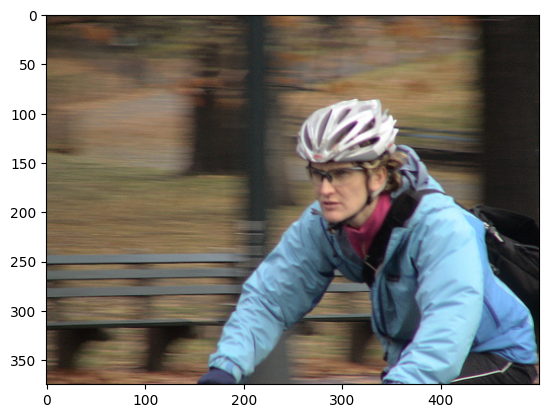

In [109]:
# Call the function with appropriate arguments
generate_caption("2084217208_7bd9bc85e5.jpg", base, model, features, tokenizer, max_length, mapping)

---------------------Actual---------------------
< two different breeds of brown and white dogs play on the beach >
< two dogs are making turn on soft sand beach >
< two dogs playing in the sand at the beach >
< two dogs playing together on beach >
< two large tan dogs play along sandy beach >
--------------------Predicted--------------------
< dog is running playing


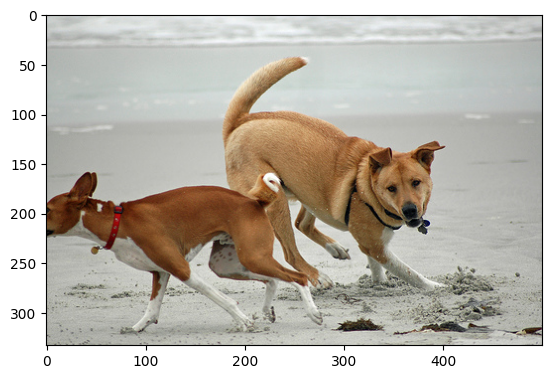

In [32]:
generate_caption("1024138940_f1fefbdce1.jpg", base, model, features, tokenizer, max_length, mapping)